In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/content/drive/MyDrive/Study/Coursera DeepLearning.AI/Machine Learning/Logistic Regression Data')
from utils import *
import copy
import math

%matplotlib inline

In [17]:
data_path = '/content/drive/MyDrive/Study/Coursera DeepLearning.AI/Machine Learning/Logistic Regression Data/ex2data1.txt'
X_train, y_train = load_data(data_path)

In [18]:
# Check first 5 values
print("First five elements in X_train are:\n", X_train[:5])
print("Type of X_train:",type(X_train))
print("First five elements in y_train are:\n", y_train[:5])
print("Type of y_train:",type(y_train))

First five elements in X_train are:
 [[34.62365962 78.02469282]
 [30.28671077 43.89499752]
 [35.84740877 72.90219803]
 [60.18259939 86.3085521 ]
 [79.03273605 75.34437644]]
Type of X_train: <class 'numpy.ndarray'>
First five elements in y_train are:
 [0. 0. 0. 1. 1.]
Type of y_train: <class 'numpy.ndarray'>


In [19]:
# Check dimensions of variables
print ('The shape of X_train is: ' + str(X_train.shape))
print ('The shape of y_train is: ' + str(y_train.shape))
print ('We have m = %d training examples' % (len(y_train)))

The shape of X_train is: (100, 2)
The shape of y_train is: (100,)
We have m = 100 training examples


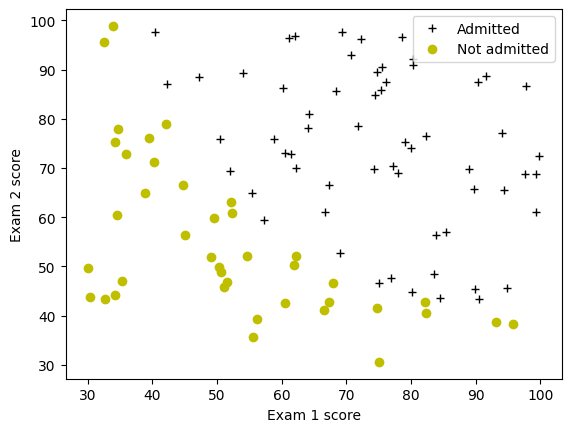

In [20]:
# Visualize data
# Plot examples
plot_data(X_train, y_train[:], pos_label="Admitted", neg_label="Not admitted")

# Set the y-axis label
plt.ylabel('Exam 2 score')
# Set the x-axis label
plt.xlabel('Exam 1 score')
plt.legend(loc="upper right")
plt.show()

In [31]:
# Sigmoid function
def sigmoid(z):
  """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z

  """

  g = 1 / (1 + np.exp(-z))
  return g

In [32]:
# Test sigmoid under different input values
value = 0

print (f"sigmoid({value}) = {sigmoid(value)}")

sigmoid(0) = 0.5


In [33]:
print ("sigmoid([ -1, 0, 1, 2]) = " + str(sigmoid(np.array([-1, 0, 1, 2]))))

# UNIT TESTS
from public_tests import *
sigmoid_test(sigmoid)

sigmoid([ -1, 0, 1, 2]) = [0.26894142 0.5        0.73105858 0.88079708]
All tests passed!


In [38]:
# Cost function
def compute_cost(X, y, w, b, *argv):
  """
    Computes the cost over all examples
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (ndarray Shape (m,))  target value
      w : (ndarray Shape (n,))  values of parameters of the model
      b : (scalar)              value of bias parameter of the model
      *argv : unused, for compatibility with regularized version below
    Returns:
      total_cost : (scalar) cost
  """
  m,n = X.shape
  total_cost = 0.0

  for i in range(m):
    z_wb = np.dot(X[i],w) + b
    f_wb_i = sigmoid(z_wb)
    total_cost += -y[i]*np.log(f_wb_i) - (1 - y[i])*np.log(1 - f_wb_i)

  total_cost /= m
  return total_cost

In [39]:
# Compute and display cost with w and b initialized to zeros
m, n = X_train.shape

initial_w = np.zeros(n)
initial_b = 0.
cost = compute_cost(X_train, y_train, initial_w, initial_b)
print('Cost at initial w and b (zeros): {:.3f}'.format(cost))

Cost at initial w and b (zeros): 0.693


In [40]:
# Compute and display cost with non-zero w and b
test_w = np.array([0.2, 0.2])
test_b = -24.
cost = compute_cost(X_train, y_train, test_w, test_b)

print('Cost at test w and b (non-zeros): {:.3f}'.format(cost))


# UNIT TESTS
compute_cost_test(compute_cost)

Cost at test w and b (non-zeros): 0.218
All tests passed!


$f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the actual label.

The model prediction is computed as:

$$
f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(\mathbf{w} \cdot \mathbf{x}^{(i)} + b)
$$

where function \( g \) is the sigmoid function.

It might be helpful to first calculate an intermediate variable:

$$
z_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b = w_0 x^{(i)}_0 + \dots + w_{n-1} x^{(i)}_{n-1} + b
$$

where \( n \) is the number of features,

before calculating

$$
f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(z_{\mathbf{w},b}(\mathbf{x}^{(i)}))
$$


$$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)}) \tag{2}
$$
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)} \tag{3}
$$

In [43]:
# Gradient function
def compute_gradient(X, y, w, b, *argv):
  """
    Computes the gradient for logistic regression

    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (ndarray Shape (m,))  target value
      w : (ndarray Shape (n,))  values of parameters of the model
      b : (scalar)              value of bias parameter of the model
      *argv : unused, for compatibility with regularized version below
    Returns
      dj_dw : (ndarray Shape (n,)) The gradient of the cost w.r.t. the parameters w.
      dj_db : (scalar)             The gradient of the cost w.r.t. the parameter b.
  """
  m, n = X.shape
  dj_dw = np.zeros(w.shape)
  dj_db = 0.

  for i in range(m):
    z_wb = 0
    for j in range(n):
      z_wb += w[j] * X[i,j]
    z_wb += b
    f_wb = sigmoid(z_wb)

    dj_db_i = f_wb - y[i]
    dj_db += dj_db_i

    for j in range(n):
      dj_dw[j] += (f_wb - y[i]) * X[i,j]

  dj_dw /= m
  dj_db /= m

  return dj_db, dj_dw

In [44]:
# Compute and display gradient with w and b initialized to zeros
initial_w = np.zeros(n)
initial_b = 0.

dj_db, dj_dw = compute_gradient(X_train, y_train, initial_w, initial_b)
print(f'dj_db at initial w and b (zeros):{dj_db}' )
print(f'dj_dw at initial w and b (zeros):{dj_dw.tolist()}' )

dj_db at initial w and b (zeros):-0.1
dj_dw at initial w and b (zeros):[-12.00921658929115, -11.262842205513591]


In [45]:
# Compute and display cost and gradient with non-zero w and b
test_w = np.array([ 0.2, -0.5])
test_b = -24
dj_db, dj_dw  = compute_gradient(X_train, y_train, test_w, test_b)

print('dj_db at test w and b:', dj_db)
print('dj_dw at test w and b:', dj_dw.tolist())

# UNIT TESTS
compute_gradient_test(compute_gradient)

dj_db at test w and b: -0.5999999999991071
dj_dw at test w and b: [-44.831353617873795, -44.37384124953978]
All tests passed!


In [50]:
# Gradient descent
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_):
  """
    Performs batch gradient descent to learn theta. Updates theta by taking
    num_iters gradient steps with learning rate alpha

    Args:
      X :  (ndarray Shape (m, n) data, m examples by n features
      y :  (ndarray Shape (m,))  target value
      w_in : (ndarray Shape (n,))  Initial values of parameters of the model
      b_in : (scalar)              Initial value of parameter of the model
      cost_function :              function to compute cost
      gradient_function :          function to compute gradient
      alpha : (float)              Learning rate
      num_iters : (int)            number of iterations to run gradient descent
      lambda_ : (scalar, float)    regularization constant

    Returns:
      w : (ndarray Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
  """
  m = len(X)

  J_history = []
  w_history = []

  for i in range(num_iters):
    dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)

    w_in = w_in - alpha * dj_dw
    b_in = b_in - alpha * dj_db

    if i<100000:
      cost =  cost_function(X, y, w_in, b_in, lambda_)
      J_history.append(cost)

    if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
      w_history.append(w_in)
      print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")

  return w_in, b_in, J_history, w_history

In [53]:
np.random.seed(1)
initial_w = 0.01 * (np.random.rand(2) - 0.5)
initial_b = -8

# Some gradient descent settings
iterations = 5000
alpha = 0.001

w,b, J_history,_ = gradient_descent(X_train ,y_train, initial_w, initial_b,
                  compute_cost, compute_gradient, alpha, iterations, 0)

Iteration    0: Cost     0.96   
Iteration  500: Cost     0.31   
Iteration 1000: Cost     0.31   
Iteration 1500: Cost     0.30   
Iteration 2000: Cost     0.30   
Iteration 2500: Cost     0.30   
Iteration 3000: Cost     0.30   
Iteration 3500: Cost     0.30   
Iteration 4000: Cost     0.30   
Iteration 4500: Cost     0.30   
Iteration 4999: Cost     0.30   


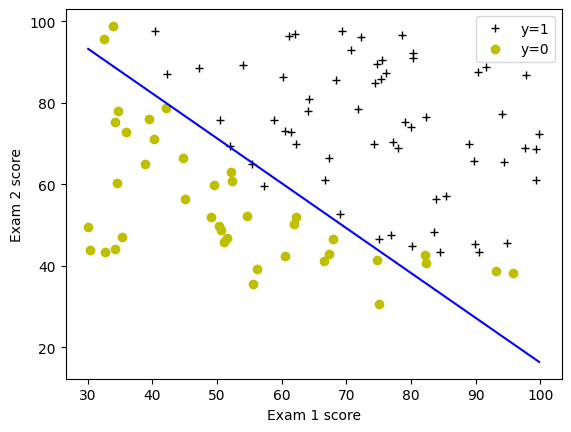

In [54]:
plot_decision_boundary(w, b, X_train, y_train)
plt.ylabel('Exam 2 score')
plt.xlabel('Exam 1 score')
plt.legend(loc="upper right")
plt.show()

In [58]:
# Predict function
def predict(X, w, b):
  """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w

    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      w : (ndarray Shape (n,))  values of parameters of the model
      b : (scalar)              value of bias parameter of the model

    Returns:
      p : (ndarray (m,)) The predictions for X using a threshold at 0.5
  """
  m, n = X.shape
  p = np.zeros(m)

  for i in range(m):
    z_wb = 0
    for j in range(n):
      z_wb += w[j] * X[i,j]

    z_wb += b
    f_wb = sigmoid(z_wb)
    p[i] = 1 if f_wb >= 0.5 else 0

  return p

In [59]:
# Test predict code
np.random.seed(1)
tmp_w = np.random.randn(2)
tmp_b = 0.3
tmp_X = np.random.randn(4, 2) - 0.5

tmp_p = predict(tmp_X, tmp_w, tmp_b)
print(f'Output of predict: shape {tmp_p.shape}, value {tmp_p}')

# UNIT TESTS
predict_test(predict)

Output of predict: shape (4,), value [0. 1. 1. 1.]
All tests passed!


In [60]:
#Compute accuracy on training set
p = predict(X_train, w,b)
print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

Train Accuracy: 92.000000


In [61]:
# load dataset
X_train, y_train = load_data('/content/drive/MyDrive/Study/Coursera DeepLearning.AI/Machine Learning/Logistic Regression Data/ex2data2.txt')

In [62]:
# print X_train
print("X_train:", X_train[:5])
print("Type of X_train:",type(X_train))

# print y_train
print("y_train:", y_train[:5])
print("Type of y_train:",type(y_train))

X_train: [[ 0.051267  0.69956 ]
 [-0.092742  0.68494 ]
 [-0.21371   0.69225 ]
 [-0.375     0.50219 ]
 [-0.51325   0.46564 ]]
Type of X_train: <class 'numpy.ndarray'>
y_train: [1. 1. 1. 1. 1.]
Type of y_train: <class 'numpy.ndarray'>


In [63]:
print ('The shape of X_train is: ' + str(X_train.shape))
print ('The shape of y_train is: ' + str(y_train.shape))
print ('We have m = %d training examples' % (len(y_train)))

The shape of X_train is: (118, 2)
The shape of y_train is: (118,)
We have m = 118 training examples


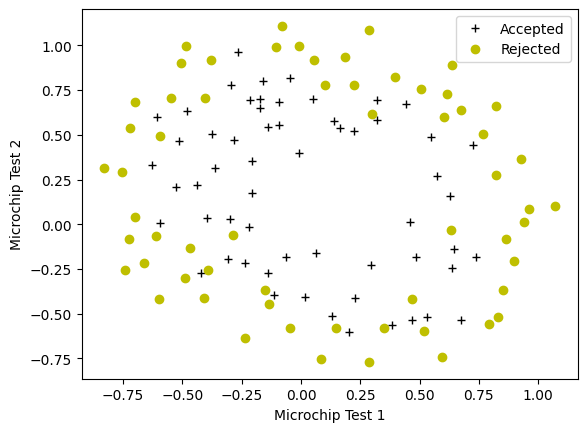

In [64]:
# Plot examples
plot_data(X_train, y_train[:], pos_label="Accepted", neg_label="Rejected")

plt.ylabel('Microchip Test 2')
plt.xlabel('Microchip Test 1')
plt.legend(loc="upper right")
plt.show()

In [65]:
print("Original shape of data:", X_train.shape)

mapped_X =  map_feature(X_train[:, 0], X_train[:, 1])
print("Shape after feature mapping:", mapped_X.shape)

Original shape of data: (118, 2)
Shape after feature mapping: (118, 27)


In [66]:
print("X_train[0]:", X_train[0])
print("mapped X_train[0]:", mapped_X[0])

X_train[0]: [0.051267 0.69956 ]
mapped X_train[0]: [5.12670000e-02 6.99560000e-01 2.62830529e-03 3.58643425e-02
 4.89384194e-01 1.34745327e-04 1.83865725e-03 2.50892595e-02
 3.42353606e-01 6.90798869e-06 9.42624411e-05 1.28625106e-03
 1.75514423e-02 2.39496889e-01 3.54151856e-07 4.83255257e-06
 6.59422333e-05 8.99809795e-04 1.22782870e-02 1.67542444e-01
 1.81563032e-08 2.47750473e-07 3.38066048e-06 4.61305487e-05
 6.29470940e-04 8.58939846e-03 1.17205992e-01]


In [67]:
# Cost function for regularized logistic regression
def compute_cost_reg(X, y, w, b, lambda_ = 1):
  """
    Computes the cost over all examples
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (ndarray Shape (m,))  target value
      w : (ndarray Shape (n,))  values of parameters of the model
      b : (scalar)              value of bias parameter of the model
      lambda_ : (scalar, float) Controls amount of regularization
    Returns:
      total_cost : (scalar)     cost
  """
  m, n = X.shape

  cost_without_reg = compute_cost(X, y, w, b)
  reg_cost = 0.
  reg_cost = (lambda_/(2 * m)) * np.sum(w**2)
  total_cost = cost_without_reg + reg_cost

  return total_cost

In [68]:
X_mapped = map_feature(X_train[:, 0], X_train[:, 1])
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1]) - 0.5
initial_b = 0.5
lambda_ = 0.5
cost = compute_cost_reg(X_mapped, y_train, initial_w, initial_b, lambda_)

print("Regularized cost :", cost)

# UNIT TEST
compute_cost_reg_test(compute_cost_reg)

Regularized cost : 0.6618252552483948
All tests passed!


In [71]:
# Gradient for regularized logistic regression
def compute_gradient_reg(X, y, w, b, lambda_ = 1):
  """
    Computes the gradient for logistic regression with regularization

    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (ndarray Shape (m,))  target value
      w : (ndarray Shape (n,))  values of parameters of the model
      b : (scalar)              value of bias parameter of the model
      lambda_ : (scalar,float)  regularization constant
    Returns
      dj_db : (scalar)             The gradient of the cost w.r.t. the parameter b.
      dj_dw : (ndarray Shape (n,)) The gradient of the cost w.r.t. the parameters w.
  """
  m, n = X.shape

  dj_db, dj_dw = compute_gradient(X, y, w, b)
  dj_dw += (lambda_ / m) * w

  return dj_db, dj_dw

In [72]:
X_mapped = map_feature(X_train[:, 0], X_train[:, 1])
np.random.seed(1)
initial_w  = np.random.rand(X_mapped.shape[1]) - 0.5
initial_b = 0.5

lambda_ = 0.5
dj_db, dj_dw = compute_gradient_reg(X_mapped, y_train, initial_w, initial_b, lambda_)

print(f"dj_db: {dj_db}", )
print(f"First few elements of regularized dj_dw:\n {dj_dw[:4].tolist()}", )

# UNIT TESTS
compute_gradient_reg_test(compute_gradient_reg)

dj_db: 0.07138288792343662
First few elements of regularized dj_dw:
 [-0.010386028450548701, 0.011409852883280124, 0.0536273463274574, 0.003140278267313462]
All tests passed!


In [74]:
# Initialize fitting parameters
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1])-0.5
initial_b = 1.

# Set regularization parameter lambda_ (you can try varying this)
lambda_ = 0.01

# Some gradient descent settings
iterations = 10000
alpha = 0.01

w,b, J_history,_ = gradient_descent(X_mapped, y_train, initial_w, initial_b,
                    compute_cost_reg, compute_gradient_reg,
                    alpha, iterations, lambda_)

Iteration    0: Cost     0.72   
Iteration 1000: Cost     0.59   
Iteration 2000: Cost     0.56   
Iteration 3000: Cost     0.53   
Iteration 4000: Cost     0.51   
Iteration 5000: Cost     0.50   
Iteration 6000: Cost     0.48   
Iteration 7000: Cost     0.47   
Iteration 8000: Cost     0.46   
Iteration 9000: Cost     0.45   
Iteration 9999: Cost     0.45   


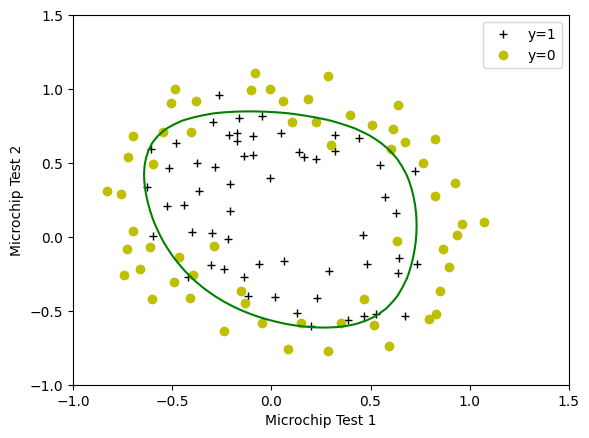

In [75]:
plot_decision_boundary(w, b, X_mapped, y_train)
plt.ylabel('Microchip Test 2')
plt.xlabel('Microchip Test 1')
plt.legend(loc="upper right")
plt.show()

In [76]:
#Compute accuracy on the training set
p = predict(X_mapped, w, b)

print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

Train Accuracy: 82.203390
